In [2]:
import h5py
from numpy import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 
plt.rcParams['font.family'] = 'Garamond'
plt.rcParams['font.size'] = 20
sns.set_theme(context="notebook")
from tqdm import tqdm

# Grinstead and Snell's Introduction to Probability?
# Cebulla, 2005: https://sci-hub.se/10.1080/14992020400029228
# if further questions: https://sci-hub.se/10.3109/00206090109073118 and https://sci-hub.se/10.3109/14992027.2015.1017659
# Chesnaye, 2019: https://sci-hub.se/10.1080/14992027.2019.1625486
# if further questions, Chesnaye,2019 CGST: https://sci-hub.se/10.1109/TBME.2019.2919696
# Chesnaye, 2019 dataset: https://eprints.soton.ac.uk/417742/
# ler depois: https://sci-hub.se/10.1080/14992027.2020.1767808

# Ordem dos eletrodos no BD-NIAS:
eletrodos = ['FC','F4','T6','P4','T4','Oz','C4','T5','P3','F7','F3','T3','C3','Fz','Pz','Cz']

### Replicando Zanotelli,2020 (MATLAB)

In [192]:
print(DET.shape)
print(HITS.shape)
print(new.shape)
print(len(P))
print(P[-2])
print(P[-2][0],P[-2][1],P[-2][2])
print(Mmax)


(120,)
(120, 1253, 11)
(8, 13783)
1253


Exame Ab


Aplicando testes: 100%|██████████| 1253/1253 [00:11<00:00, 109.54it/s]


Exame An


Aplicando testes: 100%|██████████| 1253/1253 [00:11<00:00, 111.06it/s]


Exame Bb


Aplicando testes: 100%|██████████| 1253/1253 [00:23<00:00, 53.54it/s]


Exame Er


Aplicando testes: 100%|██████████| 1253/1253 [00:12<00:00, 101.34it/s]


Exame Lu


Aplicando testes: 100%|██████████| 1253/1253 [00:27<00:00, 45.93it/s]


Exame So


Aplicando testes: 100%|██████████| 1253/1253 [00:23<00:00, 52.27it/s]


Exame Qu


Aplicando testes: 100%|██████████| 1253/1253 [00:14<00:00, 85.55it/s] 


Exame Vi


Aplicando testes: 100%|██████████| 1253/1253 [00:21<00:00, 57.89it/s]


Exame Sa


Aplicando testes: 100%|██████████| 1253/1253 [00:11<00:00, 113.25it/s]


Exame Ti


Aplicando testes: 100%|██████████| 1253/1253 [00:11<00:00, 110.64it/s]


Exame Wr


Aplicando testes: 100%|██████████| 1253/1253 [00:11<00:00, 110.11it/s]


(112, 13783)
TXD =  0.001% e FP =  0.001%


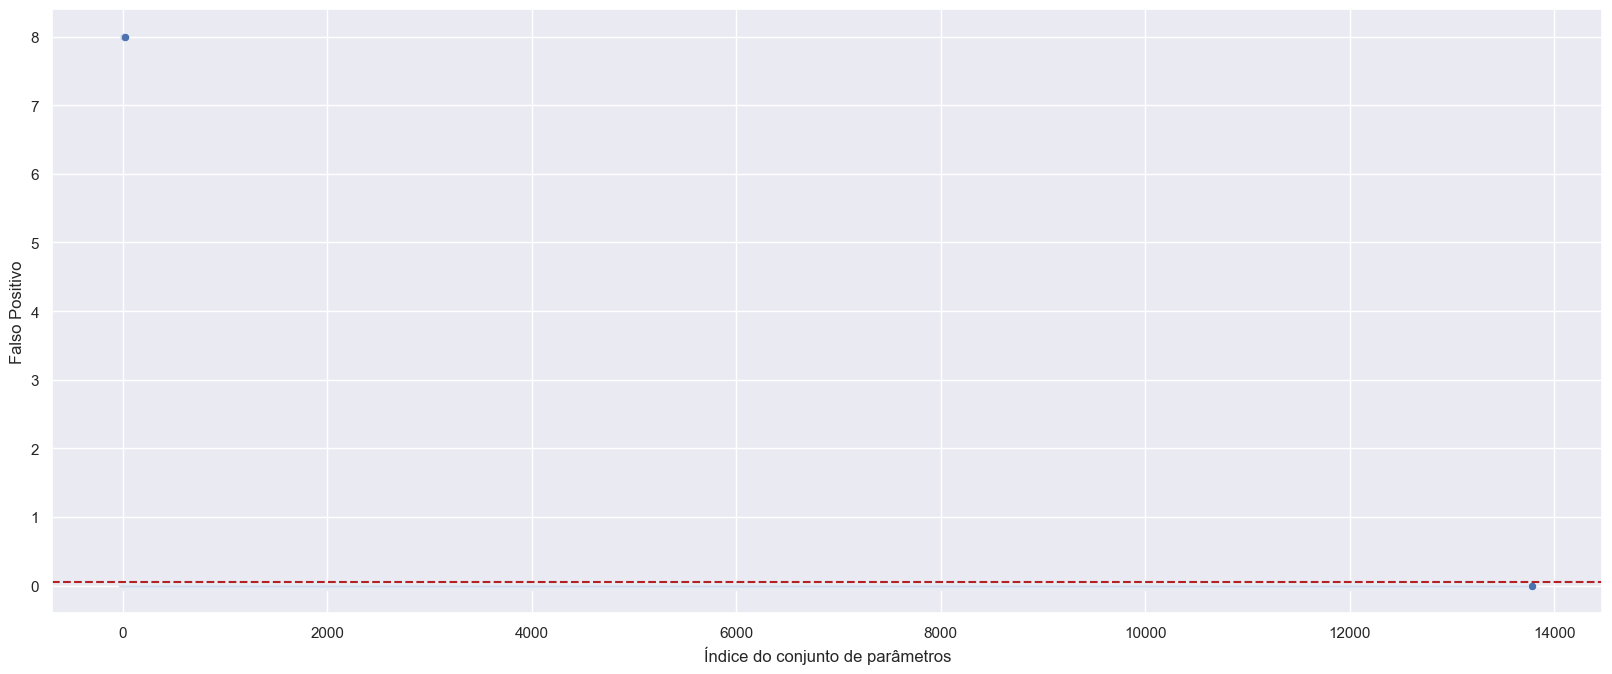

In [204]:
# Testes SMSC médio
## Dados
exames = ['Ab','An','Bb','Er','Lu','So','Qu','Vi','Sa','Ti','Wr']
# ['Ab','An','Bb','Er','Qu','Vi','Sa','Ti','Wr'] # 'Lu','So' retirados pois Njanelas pequeno
# ['Ab','An','Bb','Er','Lu','So','Qu','Vi','Sa','Ti','Wr'] # todos
binsM = [81,83,85,87,89,91,93,95]
binsR = np.arange(0,120,1)
binsR = np.delete(binsR,binsM)
# freq. 81Hz,83,85,87,89,91,93,95Hz
i=0


for ex in exames:
    caminho = 'C:/Users/alexa/Desktop/sync/NIAS_online/IC21/bd/'+str(ex)+'40dB.mat'
    x = h5py.File(caminho, 'r')['x']
    x = x[0,:,:] # Pega valores do primeiro eletrodo
    
    Fs = h5py.File(caminho, 'r')['Fs'] # alguns estão em 1750 Hz

    x2 = np.reshape(x, (x.shape[1],x.shape[0]))

    # print(x.shape)
    
    # x2 = x
    x2 = x2-np.mean(np.mean(x2))
    # x2 = x2[:,2:]

    # ganho  = 200
    # alpha = 0.05
    # remoc = .1/ganho
    # Vmax = np.max(abs(x2), axis =0)
    # ind = np.where(Vmax>remoc)

    print('Exame', ex)

    ## Parâmetros   
    P=[]
    Mmax = 450
    for Mstep in range(2,Mmax,2):        
        for Mmin in range(2,Mmax):
            k = (Mmax-Mmin)/Mstep
            if(np.ceil(k) == np.floor(k) and k>=0):
                P.append([Mmin, Mstep,Mmax])
    P.append([Mmax,1,Mmax])

    HITS = np.zeros((120,len(P),len(exames)))
    # ORDs= np.zeros((120,len(P)))

    ## Testes
    for p in tqdm(range(0,len(P)), desc = 'Aplicando testes'):
        Mmin = P[p][0]
        Mmax = P[p][1]
        Mstep = P[p][2]
        # print(Mmin,Mmax,Mstep)
        listaMs = np.arange(Mmin, Mmax+Mstep, step=Mstep)

        for j in range(0,len(listaMs)):

            M = int(listaMs[j])
            limiar = 1-(0.05)**(1/(M-1))

            SINAL = fft(x2[:,0:M])[0:120,:] # usa apenas primeiros 120 bins

            # Calcula MSC:
            ORD = (np.abs(np.sum(SINAL,axis=1))**2) / (M*np.sum(np.abs(SINAL)**2,axis=1))
            # ORDs[:,j] = ORD

            DET = np.where(ORD>limiar,1,0)

            HITS[:,j,i]= np.sum(DET)

    i+=1

new = np.reshape(HITS[binsR,:,:],(HITS[binsR,:,:].shape[0],HITS[binsR,:,:].shape[1]*HITS[binsR,:,:].shape[2]));
print(new.shape);
FP=np.mean(new,axis =0)
sns.scatterplot(data=np.mean(new,axis =0));
# plt.title('Análise de Falso Positivo')
plt.xlabel('Índice do conjunto de parâmetros')
plt.ylabel('Falso Positivo')
plt.axhline(y = 0.05, linestyle= '--', color = 'firebrick')

# plt.subplot(121);
# FP = np.mean(np.mean(HITS[binsR,:,:],axis = 2),axis=0);
# sns.boxplot(y = FP*100);
# plt.fig('a',[3,2]);
# plt.title('Taxa [%] de FALSO POSITIVO em função de M');

# plt.subplot(122);
new = np.reshape(HITS[binsM,:,:],(HITS[binsM,:,:].shape[0],HITS[binsM,:,:].shape[1]*HITS[binsM,:,:].shape[2]));
TXD = np.mean(new,axis =0)
# TXD = np.mean(np.mean(HITS[binsM,:,:],axis = 2),axis=0);
# sns.boxplot(y = TXD*100);
# plt.title('Taxa [%] de DETECÇÃO em função de M');

print('TXD = ',np.round(np.mean(TXD),3),'\b% e FP = ', np.round(np.mean(FP),3),'\b%');


In [78]:
# print(HITS[binsR,:,:].shape)
# print(np.mean(HITS[binsR,:,:],axis = 2))
# print(np.mean(HITS[binsR,:,:],axis = 2).shape)
# print(np.mean(np.mean(HITS[binsR,:,:],axis = 2),axis=0).shape)
# print(np.mean(np.mean(HITS[binsR,:,:],axis = 2),axis=0))

Text(0.5, 1.0, 'MSC nos outros Bins')

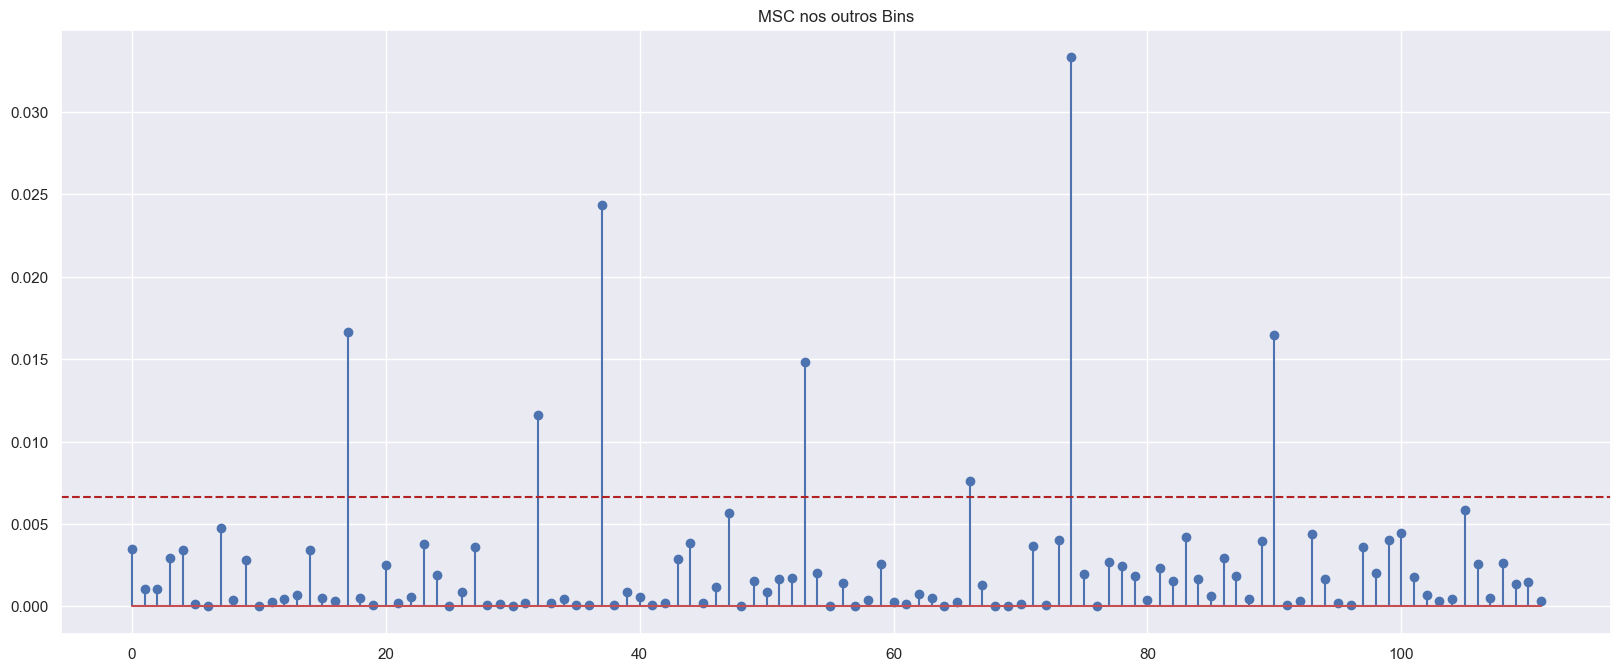

In [90]:
plt.stem(ORD[binsR])
plt.axhline(y = limiar, linestyle= '--', color = 'firebrick')
plt.title('MSC nos outros Bins')

Text(0.5, 1.0, 'MSC nos bins principais')

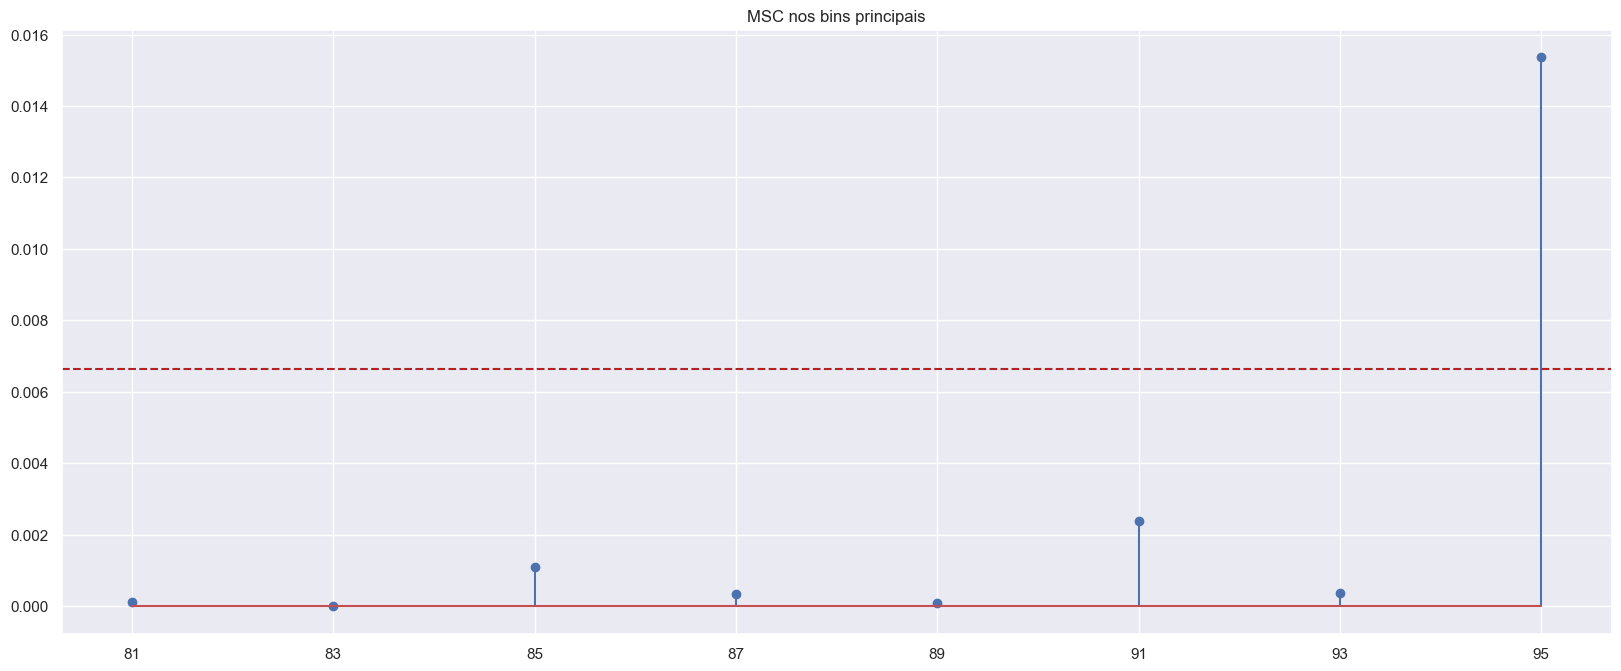

In [106]:
# plt.stem(np.abs(SINAL[:,0]))
# plt.axhline(y = limiar, linestyle= '--', color = 'firebrick')
plt.stem(binsM,ORD[binsM])
plt.xticks(binsM)
plt.axhline(y = limiar, linestyle= '--', color = 'firebrick')
plt.title('MSC nos bins principais')

### Aplicando correção de valor crítico (Cebulla, 2005)

Simulando: 100%|██████████| 10000/10000 [00:19<00:00, 511.77it/s]


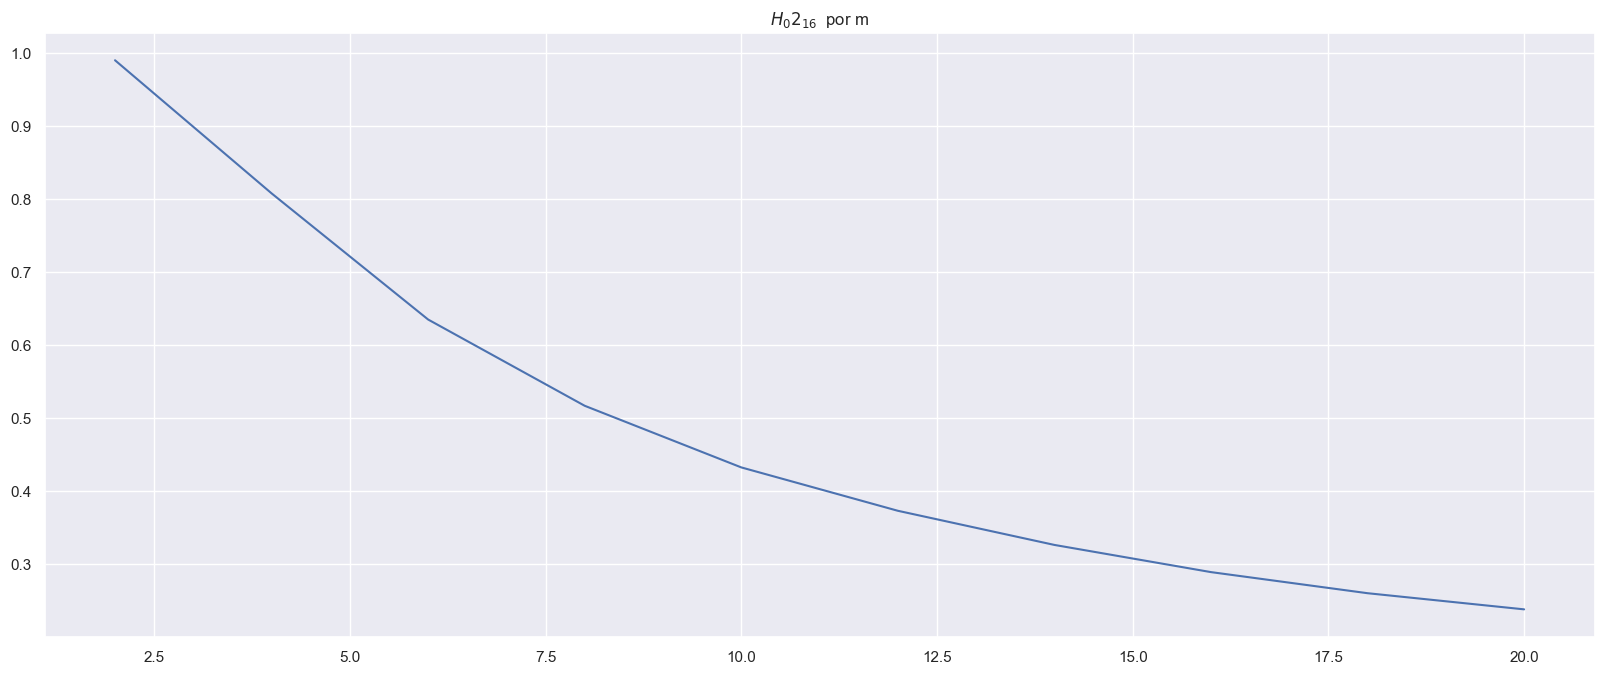

In [24]:
nSim = int(1e4) # num. de simulações (trocar para 8e6 apos validar, seguindo Cebulla, 2005)
N = int(100) # num. de pontos na senóide

energia_ruido = 1 # 1/16
listaMs = np.arange(2,22,2)
probDetec = np.zeros((len(listaMs),))
VC_16 = np.zeros((len(listaMs),nSim))
VC_1 = np.zeros((nSim,))

# buffer = []

for i in tqdm(range(nSim), desc = 'Simulando'):
    for j in range(0,len(listaMs)):
        maior = 0

        M = int(listaMs[j])
        limiar = 1-(5/100)**(1/(M-1))

        # Soma ruido aleatório novo à senóide inicial, em cada simulação:      
        SINAL = rd.randn(M,N) +1j*rd.randn(M,N) # + np.sqrt(2*(energia_ruido**2)*SNRd) parte referente à amplitude do sinal na freq.

        # Calcula MSC na f0:
        ORD = (np.abs(np.sum(SINAL,axis=0))**2) / (M*np.sum(np.abs(SINAL)**2,axis=0))
        
        if max(ORD)>maior: maior = max(ORD)
        VC_16[j,i] = maior

        
    VC_1[i] = ORD[-1]
    # VC_16[j] = max(buffer)

    # probDetec[j] = np.sum(ORD>limiar)/nSim
    # print('Probabilidade de detecção atingida:', (np.sum(ORD>limiar)/nSim)*100,'\b%')

sns.lineplot(x = listaMs,y = np.mean(VC_16,axis=1));
plt.title('$H_0$$2_{16}$  por m');

$H_0$$2_{16}$ =  0.5208267991255054
$H_0$1 0.14423591071771485
0.14586850331224344


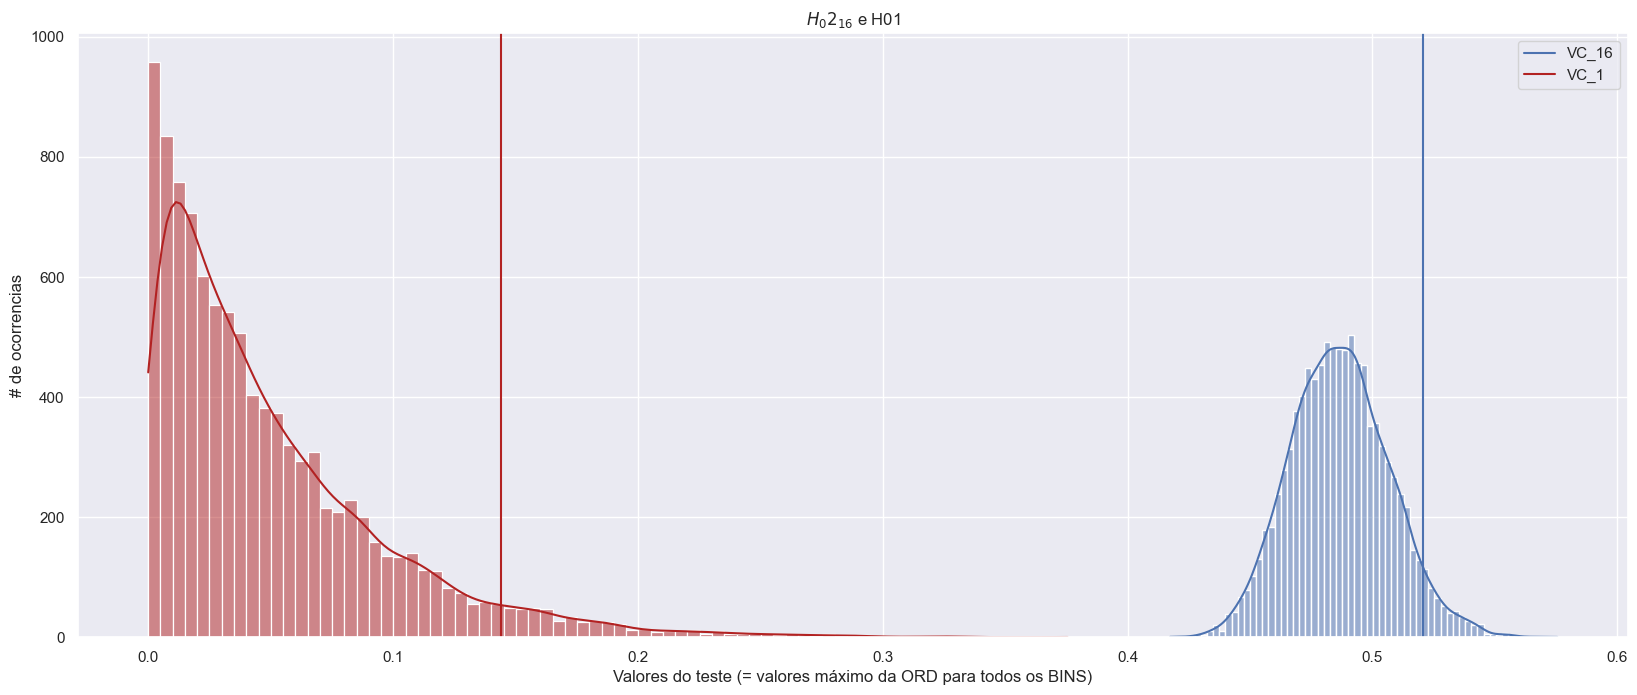

In [27]:
sns.histplot(data = np.mean(VC_16,axis=0), kde = True)
sns.histplot(data = VC_1, kde = True, color ='firebrick')
plt.title('$H_0$$2_{16}$ e H01')
plt.ylabel('# de ocorrencias')
plt.xlabel('Valores do teste (= valores máximo da ORD para todos os BINS)')
plt.legend(['VC_16','VC_1'])

limiar_VC16 = np.quantile(np.mean(VC_16,axis=0),1-0.05)
limiar_VC_1 = np.quantile(VC_1,1-0.05)

plt.axvline(x = limiar_VC16)
plt.axvline(x = limiar_VC_1, color ='firebrick')
# max(VC_16)
print('$H_0$$2_{16}$ = ',limiar_VC16)
print('$H_0$1',limiar_VC_1)
print(1-(5/100)**(1/(20-1)))

(1000, 480)
Exame Ab


Aplicando testes: 100%|██████████| 1/1 [00:00<00:00, 75.84it/s]


(1000, 480)
Exame An


Aplicando testes: 100%|██████████| 1/1 [00:00<00:00, 110.71it/s]


(1750, 480)
Exame Bb


Aplicando testes: 100%|██████████| 1/1 [00:00<00:00, 99.52it/s]


(1000, 480)
Exame Er


Aplicando testes: 100%|██████████| 1/1 [00:00<00:00, 142.78it/s]


(1750, 480)
Exame Lu


Aplicando testes: 100%|██████████| 1/1 [00:00<00:00, 99.62it/s]


(1750, 480)
Exame So


Aplicando testes: 100%|██████████| 1/1 [00:00<00:00, 99.60it/s]


(1000, 480)
Exame Qu


Aplicando testes: 100%|██████████| 1/1 [00:00<00:00, 142.84it/s]


(1750, 480)
Exame Vi


Aplicando testes: 100%|██████████| 1/1 [00:00<00:00, 83.36it/s]


(1000, 480)
Exame Sa


Aplicando testes: 100%|██████████| 1/1 [00:00<00:00, 165.22it/s]


(1000, 480)
Exame Ti


Aplicando testes: 100%|██████████| 1/1 [00:00<00:00, 155.75it/s]


(1000, 480)
Exame Wr


Aplicando testes: 100%|██████████| 1/1 [00:00<00:00, 166.78it/s]

TXD =  0.0% e FP =  0.162%


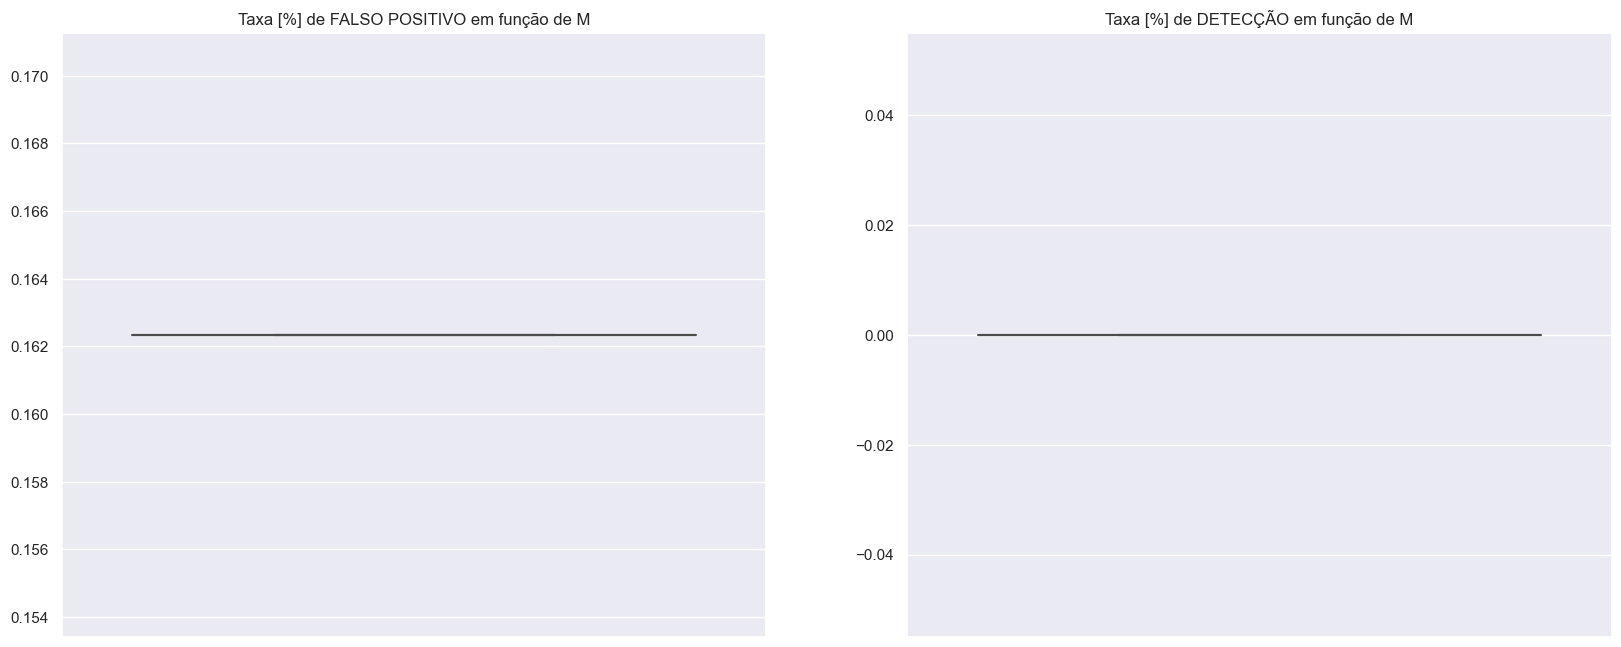

In [72]:
# Testes SMSC médio
## Dados
exames = ['Ab','An','Bb','Er','Lu','So','Qu','Vi','Sa','Ti','Wr']
# ['Ab','An','Bb','Er','Qu','Vi','Sa','Ti','Wr'] # 'Lu','So' retirados pois Njanelas pequeno
# ['Ab','An','Bb','Er','Lu','So','Qu','Vi','Sa','Ti','Wr'] # todos

binsM = [81,83,85,87,89,91,93,95]
binsR = np.arange(0,120,1)
binsR = np.delete(binsR,binsM)
#freq. 81Hz,83,85,87,89,91,93,95Hz
i=0


for ex in exames:
    caminho = 'C:/Users/alexa/Desktop/sync/NIAS_online/IC21/bd/'+str(ex)+'40dB.mat'
    x = h5py.File(caminho, 'r')['x']
    x = x[0,:,:] # Pega valores do primeiro eletrodo
    
    Fs = h5py.File(caminho, 'r')['Fs'] # alguns estão em 1750 Hz

    x2 = np.reshape(x, (x.shape[1],x.shape[0]))
    print(x2.shape)
    
    x2 = x2-np.mean(np.mean(x2))
 

    print('Exame', ex)

    ## Parâmetros
    Mmin = 450
    Mmax = 452
    Mstep = 2
    listaMs = np.arange(Mmin, Mmax, step=Mstep)
    HITS = np.zeros((120,len(listaMs),len(exames)))

    ORDs= np.zeros((len(listaMs)))

    ## Testes
    for j in tqdm(range(0,len(listaMs)), desc = 'Aplicando testes'):
        M = int(listaMs[j])
        limiar = limiar_VC16 # (Cebulla, 2005)

        SINAL = fft(x2[:,0:M])[0:120,:] # usa apenas primeiros 120 bins

        # Calcula MSC:
        ORD = (np.abs(np.sum(SINAL,axis=1))**2) / (M*np.sum(np.abs(SINAL)**2,axis=1))

        DET = np.where(ORD>limiar,1,0)

        HITS[:,j,i]= DET

    i+=1

plt.subplot(121);
FP = np.mean(np.mean(HITS[binsR,:,:],axis = 2),axis=0);
sns.boxplot(y = FP*100);
plt.title('Taxa [%] de FALSO POSITIVO em função de M');

plt.subplot(122);
TXD = np.mean(np.mean(HITS[binsM,:,:],axis = 2),axis=0);
sns.boxplot(y = TXD*100);
plt.title('Taxa [%] de DETECÇÃO em função de M');

print('TXD = ',np.round(np.mean(TXD)*100,3),'\b% e FP = ', np.round(np.mean(FP)*100,3),'\b%');


### Aplicando correção de valor crítico (Chesnaye, 2019)